&ensp; 写得比较粗糙，没有按照开发的标准进行编码。并没有将可以复用的模块变成函数，或者对于不同的临时变量使用不同的别名或者释放。有些为了验证和debug的输出也没有删除。部分内容也只是为了演示和说明添加的，可以不加入到最终成果中

## 1 导入数据

In [1]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

unique_risk = pd.read_csv('unique_risk.csv')

In [3]:
#将审核结果编码为0和1，作为一个可以进行机器学习的指标 （认为“发行股份购买资产获无条件通过”比“发行股份购买资产获有条件通过”好）
#删除公司名称列，该列无法作为特征学习的指标
unique_risk = unique_risk.drop(labels=['公司名称'], axis=1)
unique_risk['审核结果']=unique_risk['审核结果'].map({'发行股份购买资产获无条件通过':1,'发行股份购买资产获有条件通过':0})
unique_risk.head(5)

,审核结果,Rc,上一年归母净利润（万元）,承诺期业绩增长率,前三年承诺覆盖率,静态市盈率,动态市盈率,成立年限,大股东持股比例,最近一个完整会计年度对第一大客户的销售占比,...,固定资产周转率,流动比率,资产负债率,经营杠杆（EBITDA/EBIT),（固定资产+土地）/归母权益,在建工程/归母权益,净资产收益率,毛利率,经营性现金流/收入,研发支出占比
0,1,0.02,15972.0,0.20,0.27,16.47,12.84,17.94,1.00,0.39,...,928.92,1.78,0.55,1.00,0.01,0.00,0.38,0.09,0.02,0.00
1,0,0.02,4443.0,0.27,0.33,15.37,11.68,9.04,0.35,0.23,...,17.93,1.64,0.56,1.03,0.23,0.00,0.69,0.45,0.11,0.04
2,0,0.05,1417.0,0.63,0.29,34.65,14.88,6.20,0.29,0.40,...,44.80,113.26,0.01,1.01,0.02,0.00,0.74,0.93,0.51,0.28
3,1,0.01,5349.0,0.24,0.25,19.22,13.88,13.56,0.51,0.14,...,1087.77,1.37,0.73,1.02,0.01,0.00,0.23,0.06,0.00,0.00
4,1,0.01,14478.0,0.18,0.30,15.01,11.94,20.32,0.51,0.08,...,147.85,1.61,0.60,1.03,0.05,0.01,0.23,0.09,0.04,0.00


In [5]:
#按照顺序构造字典，方便将最后的特征选择结果输出为具体的属性名称
from bidict import bidict
feature_dict={
0:'审核结果',
 1:'上一年归母净利润（万元）',
 2:'承诺期业绩增长率',
 3:'前三年承诺覆盖率',
 4:'静态市盈率',
 5:'动态市盈率',
 6:'成立年限',
 7:'大股东持股比例',
 8:'最近一个完整会计年度对第一大客户的销售占比',
 9:'最近一个完整会计年度对第一供应商的采购占比',
 10:'注入资产净资产账面值(万元)',
 11:'D/(D+E)',
12:'总资产增长率' ,
 13:'归母权益增长率 ',
 14:'净利润增长率',
 15:'总资产周转率',
 16:'存货周转率',
 17:'应收账款周转率',
 18:'固定资产周转率',
 19:'流动比率',
 20:'资产负债率',
 21:'经营杠杆（EBITDA/EBIT)',
 22:'（固定资产+土地）/归母权益',
 23:'在建工程/归母权益',
 24:'净资产收益率',
 25:'毛利率',
 26:'经营性现金流/收入',
 27:'研发支出占比'
}

In [6]:
target=unique_risk['Rc']
target.head(5)

0    0.02
1    0.02
2    0.05
3    0.01
4    0.01
Name: Rc, dtype: float64

In [7]:
data=unique_risk.drop(labels=['Rc'],axis=1)
data.head(5)

,审核结果,上一年归母净利润（万元）,承诺期业绩增长率,前三年承诺覆盖率,静态市盈率,动态市盈率,成立年限,大股东持股比例,最近一个完整会计年度对第一大客户的销售占比,最近一个完整会计年度对第一供应商的采购占比,...,固定资产周转率,流动比率,资产负债率,经营杠杆（EBITDA/EBIT),（固定资产+土地）/归母权益,在建工程/归母权益,净资产收益率,毛利率,经营性现金流/收入,研发支出占比
0,1,15972.0,0.20,0.27,16.47,12.84,17.94,1.00,0.39,0.41,...,928.92,1.78,0.55,1.00,0.01,0.00,0.38,0.09,0.02,0.00
1,0,4443.0,0.27,0.33,15.37,11.68,9.04,0.35,0.23,0.13,...,17.93,1.64,0.56,1.03,0.23,0.00,0.69,0.45,0.11,0.04
2,0,1417.0,0.63,0.29,34.65,14.88,6.20,0.29,0.40,0.31,...,44.80,113.26,0.01,1.01,0.02,0.00,0.74,0.93,0.51,0.28
3,1,5349.0,0.24,0.25,19.22,13.88,13.56,0.51,0.14,0.07,...,1087.77,1.37,0.73,1.02,0.01,0.00,0.23,0.06,0.00,0.00
4,1,14478.0,0.18,0.30,15.01,11.94,20.32,0.51,0.08,0.14,...,147.85,1.61,0.60,1.03,0.05,0.01,0.23,0.09,0.04,0.00


In [8]:
# 抽取 30% 的数据作为测试集，其余作为训练集
from sklearn.model_selection import train_test_split
train, test = train_test_split(unique_risk, test_size = 0.3)

In [9]:
#分解成为特征矩阵和结果矩阵
train_X = train.drop(labels=["Rc"], axis=1)
train_y=train['Rc']

test_X= test.drop(labels=["Rc"], axis=1)
test_y =test['Rc']

In [10]:
from sklearn.preprocessing import MinMaxScaler
# 采用 Min_Max 规范化数据，保证每个特征维度的数据均值为 0，方差为 1
ss = MinMaxScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)
data = ss.fit_transform(data)

In [11]:
#PowerTransformer 类提供了两种幂变换，Yeo-Johnson transform 和 the Box-Cox transform
#df_amp = power_transform(df_amp, method='yeo-johnson') 
#我觉得没有必要，因为我用Min_MaxScaler，没有必要将数据转换成符合正态分布

两点未做事项：<br>
1.未使用 iforest算法进行异常点检车。https://www.cnblogs.com/wj-1314/p/10461816.html<br>
2.通过One-Hot或者其他方式对行业进行编码，将行业也作为一个备选属性。

## 2 不进行特征工程，直接进行机器学习

### 2.1 罗列回归模型
只是把所有我能想到的回归模型进行了罗列,实际工作一般只选择几个模型进行测试。比如最小二乘回归在一般的流程中会使用岭回归代替，随机森林是AdaBoost的特殊情况。<br>
具体模型解释参考：
https://zhuanlan.zhihu.com/p/62034592<br>
http://ster.im/py_sklearn_1/#Gradient-Boosting%E5%9B%9E%E5%BD%92

In [12]:
#最小二乘法线性回归
from sklearn import linear_model
model_LinearRegression = linear_model.LinearRegression()

# 岭回归
from sklearn.linear_model import RidgeCV
model_RidgeCV= RidgeCV()

#Lasso回归
from sklearn.linear_model import LassoCV
model_LassoCV= LassoCV()

#Elastic Net回归
from sklearn.linear_model import ElasticNetCV
model_ElasticNetCV = ElasticNetCV()

#最小角度回归（Least Angle Regression）
from sklearn.linear_model import LarsCV
model_Lars_cv = LarsCV()

#贝叶斯岭回归
from sklearn.linear_model import BayesianRidge
model_BayesianRidge=BayesianRidge()

#SGD回归
from sklearn.linear_model import SGDRegressor
model_SGDRegressor=SGDRegressor()

#SVM回归
from sklearn import svm
model_SVR = svm.SVR()

#KNN回归
from sklearn import neighbors
model_KNeighborsRegressor = neighbors.KNeighborsRegressor()

#决策树回归
from sklearn import tree
model_DecisionTreeRegressor = tree.DecisionTreeRegressor()

#MLPRegressor神经网络回归
from sklearn.neural_network import MLPRegressor
model_MLPRegressor=MLPRegressor()

#Bagging回归
from sklearn.ensemble import BaggingRegressor
model_BaggingRegressor = BaggingRegressor()

#随机森林回归
from sklearn import ensemble
model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=20)#这里使用20个决策树

#ExtraTree极端随机树回归
from sklearn.tree import ExtraTreeRegressor
model_ExtraTreeRegressor = ExtraTreeRegressor()

#Adaboost回归
from sklearn import ensemble
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(n_estimators=50)#这里使用50个决策树

#GBRT回归#
from sklearn import ensemble
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=100)#这里使用100个决策树

#LGBM回归
import lightgbm as lgb
model_LGBMRegressor= lgb.LGBMRegressor()

#XGBoost回归
import xgboost as xgb
model_XGBRegressor = xgb.XGBRegressor()

### 2.2 模型评估
&ensp; 由于数据量不够大，采用交叉验证取平均值的方法进行评估。<br> &ensp; sklearn当中使用均方误差作为评判标准时，却是计算”负均方误差“（neg_mean_squared_error）。这是因为sklearn在计算模型评估指标的时候，会考虑指标本身的性质，均方误差本身是一种误差，所以被sklearn划分为模型的一种损失(loss)，因此在sklearn当中，都以负数表示

In [13]:
#输出拟合结果和R^2分数，并且展示预测值和真实值的区别
def try_different_method(model):
    model.fit(train_X,train_y)
    score = model.score(test_X, test_y)
    result = model.predict(test_X)
    plt.figure()
    plt.plot(np.arange(len(result)), test_y,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('score: %f'%score)
    plt.legend()
    plt.show()

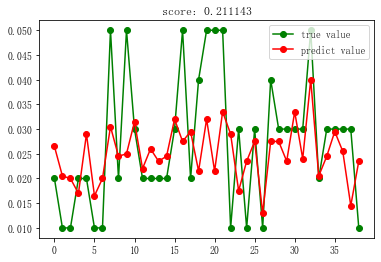

In [12]:
#举例
try_different_method(model_RandomForestRegressor)

In [98]:
#导入交叉验证包
from sklearn.model_selection import cross_val_score

计算各模型交叉验证后的r2<br>
直接使用7/3分训练集和测试集，通过几次实验，发现r^2值并不稳定，不能很好地体现各模型的效果<br>
对于有解析解的模型而言，交叉验证的结果是稳定的，可以比较好的进行说明和比较。对于没有解析解的模型，则通过多次fit()取最高值

In [14]:
#交叉验证 计算平均值
from sklearn.model_selection import cross_val_score
score=[]
score=cross_val_score(model_LinearRegression,data,target,cv=5,scoring='r2')
score.mean()

-1.6807772224692452

In [99]:
score=[]
score=cross_val_score(model_RidgeCV,data,target,cv=5,scoring='r2')
score.mean()

0.07216844123736747

In [101]:
score=[]
score=cross_val_score(model_LassoCV,data,target,cv=5,scoring='r2')
score.mean()

0.04244108783672067

In [102]:
score=[]
score=cross_val_score(model_ElasticNetCV,data,target,cv=5,scoring='r2')
score.mean()

0.04251050752099108

In [17]:
score=[]
score=cross_val_score(model_Lars_cv,data,target,cv=5,scoring='r2')
score.mean()

0.03790030147800618

In [18]:
score=[]
score=cross_val_score(model_BayesianRidge,data,target,cv=5,scoring='r2')
score.mean()

0.07150336618077066

In [20]:
score=[]
score=cross_val_score(model_SGDRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.07099009110733481

In [22]:
score=[]
score=cross_val_score(model_SVR,data,target,cv=5,scoring='r2')
score.mean()

-0.2720592899233105

In [23]:
score=[]
score=cross_val_score(model_KNeighborsRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.04005747792348944

In [47]:
score=[]
score=cross_val_score(model_DecisionTreeRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.613841983216996

In [48]:
score=[]
score=cross_val_score(model_MLPRegressor,data,target,cv=5,scoring='r2')
score.mean()

-40.985295875024775

In [53]:
score=[]
score=cross_val_score(model_BaggingRegressor,data,target,cv=5,scoring='r2')
score.mean()

0.13369234936795532

In [54]:
score=[]
score=cross_val_score(model_RandomForestRegressor,data,target,cv=5,scoring='r2')
score.mean()

0.11672347100174574

In [65]:
score=[]
score=cross_val_score(model_ExtraTreeRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.49498582598862695

In [70]:
score=[]
score=cross_val_score(model_AdaBoostRegressor,data,target,cv=5,scoring='r2')
score.mean()

0.1793746384625494

In [81]:
score=[]
score=cross_val_score(model_GradientBoostingRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.011751484128329803

In [82]:
score=[]
score=cross_val_score(model_LGBMRegressor,data,target,cv=5,scoring='r2')
score.mean()

0.037396720766279555

In [84]:
score=[]
score=cross_val_score(model_XGBRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.2345316075283665

由于SVR和多层神经网络都把数据达到高层空间，因此try_difference方法无法很好地展示情况。<br>
此外，由于模型的复杂性，因此调参能对模型产生极大的影响

In [85]:
from sklearn.model_selection import GridSearchCV  
grid = GridSearchCV(svm.SVR(), param_grid={"C":[0.1, 1, 10, 100], "gamma":[10,1, 0.1, 0.01]}, cv=5)  
grid.fit(data, target)  
print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.1, 'gamma': 10} with a score of -0.27


对于SVR，调参后交叉验证结果没有明显变化。

对MLP神经网络进行调参。默认只有一层(200,)的效果不是很好。

In [60]:
from sklearn.model_selection import GridSearchCV  
parameter_space = {
    #为了加快运行速度，删除了从(30,30,30) (30,)开始的迭代  五层或者更深可以优化效果，但会让模型过于复杂
    'hidden_layer_sizes': [(5,5,5),(3,3,3),(5,3,3,3),(5,5,5,5),(3,3,3,3)], 
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05,0.1,1,10],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(MLPRegressor(), parameter_space, cv=5)  
grid.fit(data, target)  
print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

The best parameters are {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 3, 3, 3), 'learning_rate': 'adaptive', 'solver': 'lbfgs'} with a score of -0.00


五次调参结果如下：<br>
The best parameters are {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 3, 3, 3), 'learning_rate': 'constant', 'solver': 'lbfgs'} with a score of -0.02<br>
The best parameters are {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate': 'adaptive', 'solver': 'lbfgs'} with a score of -0.01<br>
The best parameters are {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 3, 3, 3), 'learning_rate': 'constant', 'solver': 'lbfgs'} with a score of -0.01<br>
The best parameters are {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5, 5, 5), 'learning_rate': 'adaptive', 'solver': 'lbfgs'} with a score of -0.01<br>
The best parameters are {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (3, 3, 3), 'learning_rate': 'adaptive', 'solver': 'lbfgs'} with a score of -0.00<br>

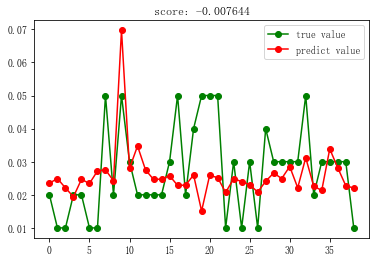

In [91]:
from sklearn.neural_network import MLPRegressor
model_MLPRegressor=MLPRegressor(activation='tanh', alpha=0.0001, hidden_layer_sizes=(3,3,3), learning_rate='adaptive', solver='lbfgs')
try_different_method(model_MLPRegressor)

In [93]:
score=[]
score=cross_val_score(model_MLPRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.043224784492351606

&emsp;&emsp;对于神经网络，调参可以有效地优化模型，使得模型的误差显著变小。在表现差距不大的情况下，模型越简单，越具有可解释性，越容易计算。<br>
我觉得比较理想的参数是  activation='tanh', alpha=0.0001, hidden_layer_sizes=(3,3,3), learning_rate='adaptive', solver='lbfgs'

尝试除了Decisiion Tree外其他的弱分类器AdaBoost

In [94]:
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(model_Lars_cv,n_estimators=50)

In [95]:
score=[]
score=cross_val_score(model_AdaBoostRegressor,data,target,cv=5,scoring='r2')
score.mean()

0.08287474418817406

In [96]:
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(model_LGBMRegressor,n_estimators=50)

In [97]:
score=[]
score=cross_val_score(model_AdaBoostRegressor,data,target,cv=5,scoring='r2')
score.mean()

0.14604652070877583

In [98]:
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(MLPRegressor(activation='tanh', alpha=0.0001, hidden_layer_sizes=(3,3,3), learning_rate='adaptive', solver='lbfgs'),n_estimators=50)

In [100]:
score=[]
score=cross_val_score(model_AdaBoostRegressor,data,target,cv=5,scoring='r2')
score.mean()

-0.060884807192556824

根据结果，使用不同的弱分类器并不能表现得比默认的决策更好，因此不修改base_estimator参数 只对n_estimators进行调优

在不调参以及进行特征选择的基础上，通过交叉验证得到各模型结果如下<br>

|模型              |R^2              |是否稳定|
|----------------|----------------------|------|
|Adaboost回归      |0.1794         |不稳定   |
|Bagging回归       |0.1337      |不稳定   |
|随机森林回归          |0.1167         |不稳定   |
|岭回归             |0.0722        |稳定    |
|贝叶斯岭回归          |0.0715        |稳定    |
|Elastic Net回归   |0.0425         |稳定    |
|Lasso回归         |0.0424         |稳定    |
|最小角度回归          |0.0379          |稳定    |
|LGBM回归          |0.0221          |稳定    |
|GBRT回归          |-0.0118          |不稳定   |
|KNN回归           |-0.0401         |稳定    |
|神经网络回归（调参后）          |-0.0432      |不稳定   |
|SGD回归           |-0.0710           |不稳定   |
|XGBoost回归       |-0.2343      |稳定    |
|SVM回归           |-0.2721       |稳定    |
|ExtraTree极端随机树回归|-0.4937         |不稳定   |
|决策树回归           |-0.6138          |不稳定   |
|最小二乘法线性回归       |-1.6808         |稳定    |
|神经网络回归（调参前）          |-40.9853         |不稳定   |


&emsp;&emsp;不稳定指的是由于模型没有解析解，因此每次通过fit()函数调用产生的结果不同。因此对于像神经网络等模型在获得一个比较好的结果后需要通过如下代码进行持久化保存。<br>
&emsp;&emsp;岭回归，Lasso回归和弹性网回归已经进行了一定程度上的特征选择，没有特别大的改进空间。

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'filename.pkl') #保存fit()结果  
clf = joblib.load('filename.pkl')  #加载文件


&emsp;&emsp;线性回归模型的表现普遍不是很好。从最小二乘法到Elastic Net回归由于添加了惩罚项，在一定程度上进行了特征选择。贝叶斯岭和SGD岭回归只是将参数估计方法从最小二乘变成最大化边际对数似然和随机梯度下降。<br>
SVM回归因此表现不佳。<br>
&emsp;&emsp;MLP神经网络调参后具有不错的表现，但随着隐藏层的增加会变得难以解释： a(b(c(d(x))))还原成a(x)的难度太大了<br>
&emsp;&emsp;KNN回归的思想是寻找最近的几个点，求加权平均；树回归本质是将区域分成多个区域。<br>
&emsp;&emsp;集成回归模型一般都能将弱分类器变成一个表现较好的分类器。

&emsp;&emsp;对SVR进行调优后，并没有明显的优化。~~之后只对AdaBoost回归（随机森林也可以理解为AdaBoost的特殊情况），Bagging回归 进行特征选择和调优，选择比较好的模型。~~(待定  我再试试吧)

## 3 特征选择

不考虑通过PolynomialFeatures构造 如x^2, xy等多项式特征，我觉得这种特征对于该问题没有意义

### 3.1 特征选择: Filter
&emsp;&emsp;基本思路是通过统计学变量，计算自变量和目标变量之间的关联。<br>
&emsp;&emsp;相关系数，卡方检验，信息增益：互信息。

&ensp; 这部分不算我的强项，感觉做的其实没有原有的成果好，这个暂时先搁置了，后期看是否决定有时间补充。

<AxesSubplot:>

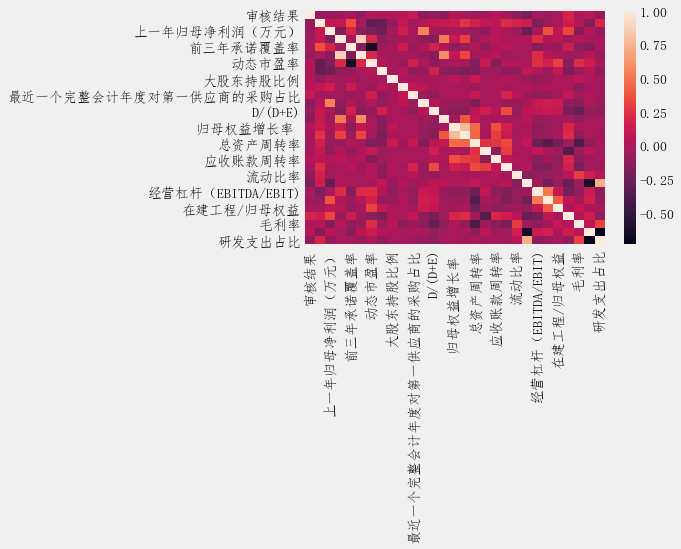

In [34]:
# 用Seaborn 生成热图
import seaborn as sns
import matplotlib.style as style
# 选用一个干净的主题
style.use('fivethirtyeight')
sns.heatmap(unique_risk.corr())

In [35]:
# 只留下相关系数超过正负0.2 的特征
unique_risk.corr()['Rc'].abs() > .2

审核结果                     False
Rc                        True
上一年归母净利润（万元）             False
承诺期业绩增长率                 False
前三年承诺覆盖率                  True
静态市盈率                    False
动态市盈率                     True
成立年限                      True
大股东持股比例                  False
最近一个完整会计年度对第一大客户的销售占比    False
最近一个完整会计年度对第一供应商的采购占比    False
注入资产净资产账面值(万元)           False
D/(D+E)                  False
总资产增长率                   False
归母权益增长率                  False
净利润增长率                    True
总资产周转率                   False
存货周转率                    False
应收账款周转率                  False
固定资产周转率                   True
流动比率                     False
资产负债率                    False
经营杠杆（EBITDA/EBIT)        False
（固定资产+土地）/归母权益           False
在建工程/归母权益                False
净资产收益率                   False
毛利率                      False
经营性现金流/收入                False
研发支出占比                   False
Name: Rc, dtype: bool

In [40]:
# 存储特征
highly_correlated_features =unique_risk.columns[unique_risk.corr()['Rc'].abs() > .2]
highly_correlated_features=highly_correlated_features.drop('Rc') 
highly_correlated_features

Index(['前三年承诺覆盖率', '动态市盈率', '成立年限', '净利润增长率', '固定资产周转率'], dtype='object')

In [100]:
score=[]
score=cross_val_score(model_RidgeCV,data,target,cv=5,scoring='r2')
score.mean()

0.07216844123736747

In [101]:
new_data=unique_risk[['前三年承诺覆盖率', '动态市盈率', '成立年限', '净利润增长率', '固定资产周转率']]
new_data.head(5)

,前三年承诺覆盖率,动态市盈率,成立年限,净利润增长率,固定资产周转率
0,0.27,12.84,17.94,0.16,928.92
1,0.33,11.68,9.04,1.85,17.93
2,0.29,14.88,6.20,0.80,44.80
3,0.25,13.88,13.56,0.23,1087.77
4,0.30,11.94,20.32,0.16,147.85


In [102]:
new_data=ss.fit_transform(new_data)

In [103]:
score=[]
score=cross_val_score(model_RidgeCV,new_data,target,cv=5,scoring='r2')
score.mean()

0.11034517626414612

进行特征选择可以优化提升模型的效果

### 3.2 特征选择：Wrapper
思路：通过目标函数来决定是否加入一个变量。

最佳子集回归（Best Subset Regression）<br>
通过遍历所有可能的组合，找出最好的特征组合。<br>
由于 $C_{n}^{1}+C_{n}^{2}+C_{n}^{3}+ ... +C_{n}^{n}=2^n$  &emsp; 因此对于具有大量属性(20个以上，2^20=1048576，建议跑分布式解决)的问题，这个方法并不适用。

In [ ]:
#不运行
results = pd.DataFrame(columns=['num_features', 'features', 'R2'])


for k in range(1, X_train.shape[1] + 1):
    for subset in itertools.combinations(range(X_train.shape[1]), k):
        linreg_model = LinearRegression.fit(X_train[:, subset], y_train)
        score = linreg_model.score(X_train[:, subset],y_train)
        results = results.append(pd.DataFrame([{'num_features': k, 'features': subset,'R2': score}]))

# 根据R^2的值进行排序
results = results.sort_values('R2').reset_index()
print(results.head())

# 拟合最优模型

# get corresponding feature describe
feature_describe = data.columns.tolist()[1:-2]
best_subset_feature_index = results['features'][0]
best_subset_feature_describe = []
for index in best_subset_feature_index:
    best_subset_feature_describe.append(feature_describe[index])


best_subset_model = LinearRegression(normalize=True).fit(X_train[:, results['features'][0]], y_train)
best_subset_coefs = dict(
    zip(['Intercept'] + best_subset_feature_describe,
        np.round(np.concatenate((best_subset_model.intercept_, best_subset_model.coef_), axis=None), 3))
)

print('Best Subset Regression R2: {}'.format(np.round(results['R2'][0], 3)))
print('Best Subset Regression coefficients:', best_subset_coefs)

feature_selection.RFECV，递归特征消除法<BR>
&emsp;&emsp;递归特征删除法,不断训练模型，每次训练完毕删除掉n个重要性低的特征，然后对新的特征再次进行训练，又一次得到特征重要性，再次删除n个重要性低的特征，直到特征数满足自己的设定。通过交叉验证来找到最优的特征数量，这里的交叉验证与我们经常见到的不同，不是不同行组合然后求平均，而是不同列的组合求均值，得到最优的特征数量。如果减少特征会造成性能损失，那么将不会去除任何特征。

In [14]:
#对于AdaBoost通过RFECV进行特征选择
from sklearn.feature_selection import RFECV
from sklearn import ensemble

estimator = ensemble.AdaBoostRegressor(n_estimators=50)

# 5折交叉
selector = RFECV(estimator, step=1, cv=5,scoring='r2')
selector = selector.fit(data, target)

# 哪些特征入选最后特征，true表示入选
print(selector.support_)

# 每个特征的得分排名，特征得分越低（1最好），表示特征越好
print(selector.ranking_)

#  挑选了几个特征
print(selector.n_features_)
# 每次交叉迭代各个特征得分
print(selector.grid_scores_)

[False  True  True  True False  True  True  True False False False  True
  True False False  True False False False False False False False False
  True False False False]
[19  1  1  1  5  1  1  1 10  6  9  1  1 12  8  1 11  4 15  2  3 13 18 17
  1  7 14 16]
10
[-0.25792345  0.04099363  0.03420285 -0.00697929  0.05958269  0.10164545
  0.10468535  0.09450692  0.12463406  0.16445999  0.07878808  0.1140803
  0.09394951  0.10246628  0.06732129  0.05148448  0.03886603  0.08873608
  0.08441182  0.1263461   0.06769718  0.12344167  0.12110685  0.09204827
  0.1019819   0.12426022  0.12036948  0.08986083]


In [16]:
for i in range(len(selector.support_)):
    if selector.support_[i]:
        print(feature_dict[i])

上一年归母净利润（万元）
承诺期业绩增长率
前三年承诺覆盖率
动态市盈率
成立年限
大股东持股比例
D/(D+E)
总资产增长率
总资产周转率
净资产收益率


In [17]:
selector.estimator_.feature_importances_

array([0.07110668, 0.09902093, 0.14318283, 0.08508161, 0.11968015,
       0.09005091, 0.13734989, 0.10678442, 0.0830795 , 0.06466307])

In [28]:
result={"上一年归母净利润（万元）":0.07110668,
"承诺期业绩增长率":0.09902093,
"前三年承诺覆盖率":0.14318283,
"动态市盈率":0.08508161,
"成立年限":0.11968015,
"大股东持股比例":0.09005091,
"D/(D+E)": 0.13734989,
"总资产增长率":0.10678442,
"总资产周转率":0.0830795, 
"净资产收益率":0.06466307
}
dict(sorted(result.items(), key=lambda item: item[1],reverse=True))

{'前三年承诺覆盖率': 0.14318283,
 'D/(D+E)': 0.13734989,
 '成立年限': 0.11968015,
 '总资产增长率': 0.10678442,
 '承诺期业绩增长率': 0.09902093,
 '大股东持股比例': 0.09005091,
 '动态市盈率': 0.08508161,
 '总资产周转率': 0.0830795,
 '上一年归母净利润（万元）': 0.07110668,
 '净资产收益率': 0.06466307}

In [87]:
#对于岭回归通过RFECV进行特征选择
from sklearn.feature_selection import RFECV
from sklearn import ensemble

estimator = RidgeCV()

# 5折交叉
selector = RFECV(estimator, step=1, cv=5,scoring='r2')
selector = selector.fit(data, target)

# 哪些特征入选最后特征，true表示入选
print(selector.support_)

# 每个特征的得分排名，特征得分越低（1最好），表示特征越好
print(selector.ranking_)

#  挑选了几个特征
print(selector.n_features_)
# 每次交叉迭代各个特征得分
print(selector.grid_scores_)

[False False  True  True False  True  True  True  True False  True  True
 False False  True False  True False  True  True  True  True False False
  True  True False  True]
[ 7  4  1  1  6  1  1  1  1 12  1  1  8  9  1  3  1 10  1  1  1  1 11  2
  1  1  5  1]
17
[-0.10691103 -0.08792981  0.0015108   0.03089925  0.07394255  0.08930557
  0.07740238  0.08327563  0.10622224  0.10033636  0.10105676  0.09348613
  0.10436005  0.11092395  0.11441851  0.11931348  0.1267853   0.0973484
  0.10746511  0.09691629  0.07914468  0.0722563   0.07170838  0.06812256
  0.07063101  0.07087806  0.07183719  0.07216844]


In [88]:
selector.estimator_.coef_

array([ 0.00622631,  0.01141003, -0.0082583 , -0.00984573, -0.00617567,
        0.00667129,  0.00539275,  0.00687357,  0.0141159 ,  0.0071212 ,
        0.00791002,  0.00944786,  0.00723763, -0.00530948,  0.00571086,
        0.00510503,  0.00761793])

In [90]:
result={'承诺期业绩增长率':0.00622631,
'前三年承诺覆盖率':0.01141003,
'动态市盈率':-0.0082583,
'成立年限':-0.00984573,
'大股东持股比例':-0.00617567,
'最近一个完整会计年度对第一大客户的销售占比':0.00667129,
'注入资产净资产账面值(万元)':0.00539275,
'D/(D+E)':0.00687357,
'净利润增长率':0.0141159,
'存货周转率':0.0071212,
'固定资产周转率':0.00791002,
'流动比率':0.00944786,
'资产负债率':0.00723763,
'经营杠杆（EBITDA/EBIT)':-0.00530948,
'净资产收益率': 0.00571086,
'毛利率':0.00510503,
'研发支出占比':0.00761793}
dict(sorted(result.items(), key=lambda item: abs(item[1]),reverse=True))

{'净利润增长率': 0.0141159,
 '前三年承诺覆盖率': 0.01141003,
 '成立年限': -0.00984573,
 '流动比率': 0.00944786,
 '动态市盈率': -0.0082583,
 '固定资产周转率': 0.00791002,
 '研发支出占比': 0.00761793,
 '资产负债率': 0.00723763,
 '存货周转率': 0.0071212,
 'D/(D+E)': 0.00687357,
 '最近一个完整会计年度对第一大客户的销售占比': 0.00667129,
 '承诺期业绩增长率': 0.00622631,
 '大股东持股比例': -0.00617567,
 '净资产收益率': 0.00571086,
 '注入资产净资产账面值(万元)': 0.00539275,
 '经营杠杆（EBITDA/EBIT)': -0.00530948,
 '毛利率': 0.00510503}

In [91]:
#对于LGBM回归通过RFECV进行特征选择
from sklearn.feature_selection import RFECV

estimator = lgb.LGBMRegressor()

# 5折交叉
selector = RFECV(estimator, step=1, cv=5,scoring='r2')
selector = selector.fit(data, target)

# 哪些特征入选最后特征，true表示入选
print(selector.support_)

# 每个特征的得分排名，特征得分越低（1最好），表示特征越好
print(selector.ranking_)

#  挑选了几个特征
print(selector.n_features_)
# 每次交叉迭代各个特征得分
print(selector.grid_scores_)

[False False  True False  True  True  True  True False False  True False
  True False False  True  True  True False  True  True False False False
  True  True False False]
[15  9  1  4  1  1  1  1 10  2  1  7  1  5  8  1  1  1  3  1  1 11 12 14
  1  1  6 13]
14
[-0.08087455 -0.08321782 -0.16552435 -0.17220495 -0.16254833 -0.14615131
 -0.07867268 -0.04929552 -0.02525918 -0.01269313 -0.01987514 -0.03203186
  0.03445237  0.0866951   0.06231025  0.01852797  0.0404062   0.04590875
  0.00245121  0.01909081  0.03801592  0.04989523  0.05600172  0.04510203
  0.04755616  0.04755459  0.03896927  0.03739672]


In [92]:
for i in range(len(selector.support_)):
    if selector.support_[i]:
        print(feature_dict[i])

承诺期业绩增长率
静态市盈率
动态市盈率
成立年限
大股东持股比例
注入资产净资产账面值(万元)
总资产增长率
总资产周转率
存货周转率
应收账款周转率
流动比率
资产负债率
净资产收益率
毛利率


In [86]:
selector.estimator_.feature_importances_

array([25, 34, 42, 27, 31, 30, 32, 23, 28, 27, 35, 22, 24, 27])

In [94]:
result={'承诺期业绩增长率':25,
'静态市盈率':34,
'动态市盈率':42,
'成立年限':27,
'大股东持股比例':31,
'注入资产净资产账面值(万元)':30,
'总资产增长率':32,
'总资产周转率':23,
'存货周转率':28,
'应收账款周转率':27,
'流动比率':35,
'资产负债率':22,
'净资产收益率':24,
'毛利率':27}
dict(sorted(result.items(), key=lambda item: abs(item[1]),reverse=True))

{'动态市盈率': 42,
 '流动比率': 35,
 '静态市盈率': 34,
 '总资产增长率': 32,
 '大股东持股比例': 31,
 '注入资产净资产账面值(万元)': 30,
 '存货周转率': 28,
 '成立年限': 27,
 '应收账款周转率': 27,
 '毛利率': 27,
 '承诺期业绩增长率': 25,
 '净资产收益率': 24,
 '总资产周转率': 23,
 '资产负债率': 22}

由于神经网络没有 coef_ 或 feature_importances_ 属性，因此无法通过RFECV属性进行特征选择。<br>
注：MLP的coef_返回的并不是属性的系数，而是返回一个矩阵表示神经网络每个连接之间的权重。即对于f(a(b(c(x))))中 a,b,c中的系数，不能直接输出f(x)中的系数 

In [95]:
#对于MLP回归通过RFECV进行特征选择
from sklearn.feature_selection import RFECV

estimator = MLPRegressor(activation='tanh', alpha=0.0001, hidden_layer_sizes=(3,3,3), learning_rate='adaptive', solver='lbfgs')

# 5折交叉
selector = RFECV(estimator, step=1, cv=5,scoring='r2')
selector = selector.fit(data, target)

# 哪些特征入选最后特征，true表示入选
print(selector.support_)

# 每个特征的得分排名，特征得分越低（1最好），表示特征越好
print(selector.ranking_)

#  挑选了几个特征
print(selector.n_features_)
# 每次交叉迭代各个特征得分
print(selector.grid_scores_)

ValueError: when `importance_getter=='auto'`, the underlying estimator MLPRegressor should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

RReliefF  (Relief for Regression)<br>
&emsp;没搞明白这个算法，也没有一个比较好用的包直接使用，有空再补充吧<br>
&emsp;&emsp;https://stats.stackexchange.com/questions/198116/rrelieff-algorithm-for-regression-for-feature-selection-with-an-example<br>
&emsp;&emsp;https://www.pythonf.cn/read/147824<br>
&emsp;&emsp;https://www.kaggle.com/jorgesandoval/feature-selection-with-rrelieff-regression <br>
&emsp;&emsp;http://www.ecice06.com/CN/10.3969/j.issn.1000-3428.2017.08.035

In [ ]:
import sklearn_relief as sr
r=sr.RReliefF(n_features=5)# Choose the best n features
r.fit_transform(data,target)

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
nof_list=np.arange(1,20)            
high_score=0
nof=0           
score_list =[]
for n in range(len(nof_list)):
    fs = sr.RReliefF(n_features = nof_list[n])
    relief = Pipeline([('fs', fs), ('m', RandomForestRegressor())])
    relief.fit(data,target)
    score = relief.score(X_test,y_test)
    score_list.append(score)
    print(f'NOF: {nof_list[n]}, Score: {score}')
    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print (print(f'High Score: NOF: {nof}, Score: {high_score}'))

NOF: 1, Score: 0.6347326458040294
NOF: 2, Score: 0.852723785926659
NOF: 3, Score: 0.8793435084241812
NOF: 4, Score: 0.8647368681863218
NOF: 5, Score: 0.8701481665014856
NOF: 6, Score: 0.8456137264618422
NOF: 7, Score: 0.8681923686818622
NOF: 8, Score: 0.8720575817641218
NOF: 9, Score: 0.8889311694747266
NOF: 10, Score: 0.9057506442021794
NOF: 11, Score: 0.8600483647175408
NOF: 12, Score: 0.877093954410306
NOF: 13, Score: 0.8816297819623378
NOF: 14, Score: 0.9047495540138741
NOF: 15, Score: 0.8824279484638243
NOF: 16, Score: 0.8897563924677889
NOF: 17, Score: 0.8787366699702666
NOF: 18, Score: 0.8868516848364706
NOF: 19, Score: 0.899775024777006
High Score: NOF: 10, Score: 0.9057506442021794
None


### 3.3 特征选择：Embedded
&emsp;&emsp;学习器自身自动选择特征。其中正则化已经通过岭回归，Lasso回归,弹性网回归和最小角度模型实现，接下来尝试在参数上进行优化，找出更好的特征<br>
还可以通过决策树：熵、信息增益来学习

In [38]:
#RidgeCV回归
from sklearn.model_selection import cross_validate

reg = RidgeCV()
cv_results = cross_validate(reg,data, target, cv=5, return_estimator=True)


coef=[]
intercept=[]

print("每次的系数和截距为：")
for model in cv_results['estimator']:
    coef.append(model.coef_)
    intercept.append(model.intercept_)
    print(model.coef_)
    print(model.intercept_)

print("\n")

print("每次测试集的R2为：")
for score in cv_results['test_score']:
    print(score)
print("R2的平均值为"+str(cv_results['test_score'].mean()))    
print("\n")

print("系数和截距的平均值为：")
print(np.mean(coef, axis = 0))
print(np.mean(intercept, axis = 0))

每次的系数和截距为：
[ 2.13366409e-03 -2.55153693e-03  3.21858695e-03  1.52370141e-02
 -3.02337156e-03 -6.35255369e-03 -7.14947428e-03 -6.93799658e-03
  5.81170216e-03 -2.13230827e-03  4.85143484e-03  5.50704470e-03
 -3.05491620e-05  7.54559984e-04  1.16546009e-02  6.36859568e-03
  6.24746584e-03 -2.81592970e-03  9.54516317e-03 -9.18037942e-04
  1.97351561e-03 -5.41121208e-03 -1.66779443e-03  6.31827455e-03
  5.61061323e-03  2.20764511e-03  8.89151123e-04 -8.26592330e-04]
0.015126972701343175
[-0.00091732  0.00199008  0.00738018  0.00907007  0.000788   -0.00915763
 -0.00874065 -0.00672987  0.00723543 -0.00025145  0.00596855  0.00635674
  0.00078868  0.00293904  0.01066868  0.00304335  0.00704225  0.00173024
  0.00099208  0.00846207  0.00531669 -0.00810774 -0.00285679  0.00490512
  0.00732175  0.00748404 -0.00113312  0.00795599]
0.01635686315817927
[-0.00026738  0.00401345  0.00612077  0.01287841 -0.0008928  -0.00710185
 -0.01156903 -0.00666976  0.00636457 -0.00152523  0.00582481  0.00567897
  0.

In [39]:
coef=np.absolute(np.mean(coef, axis = 0))
coef

array([0.00097974, 0.00199735, 0.00589533, 0.01128383, 0.00132141,
       0.0074311 , 0.00920761, 0.00570747, 0.00517881, 0.00074616,
       0.00358469, 0.00613134, 0.00111062, 0.00136786, 0.01053132,
       0.00312534, 0.00590651, 0.00063432, 0.00655812, 0.00690532,
       0.00511215, 0.00504682, 0.00078197, 0.00369158, 0.00533227,
       0.00532675, 0.00111332, 0.00536439])

In [41]:
sorted_id = sorted(range(len(coef)), key=lambda k: coef[k], reverse=True)
print('元素索引序列：', sorted_id)

元素索引序列： [3, 14, 6, 5, 19, 18, 11, 16, 2, 7, 27, 24, 25, 8, 20, 21, 23, 10, 15, 1, 13, 4, 26, 12, 0, 22, 9, 17]


In [43]:
for i in sorted_id:
    print(feature_dict[i])

前三年承诺覆盖率
净利润增长率
成立年限
动态市盈率
流动比率
固定资产周转率
D/(D+E)
存货周转率
承诺期业绩增长率
大股东持股比例
研发支出占比
净资产收益率
毛利率
最近一个完整会计年度对第一大客户的销售占比
资产负债率
经营杠杆（EBITDA/EBIT)
在建工程/归母权益
注入资产净资产账面值(万元)
总资产周转率
上一年归母净利润（万元）
归母权益增长率 
静态市盈率
经营性现金流/收入
总资产增长率
审核结果
（固定资产+土地）/归母权益
最近一个完整会计年度对第一供应商的采购占比
应收账款周转率


In [54]:
# LassoCV回归
from sklearn.model_selection import cross_validate

reg = LassoCV()
cv_results = cross_validate(reg,data, target, cv=5, return_estimator=True)


coef=[]
intercept=[]

print("每次的系数和截距为：")
for model in cv_results['estimator']:
    coef.append(model.coef_)
    intercept.append(model.intercept_)
    print(model.coef_)
    print(model.intercept_)

print("\n")

print("每次测试集的R2为：")
for score in cv_results['test_score']:
    print(score)
print("R2的平均值为"+str(cv_results['test_score'].mean()))    
print("\n")

print("系数和截距的平均值为：")
print(np.mean(coef, axis = 0))
print(np.mean(intercept, axis = 0))

每次的系数和截距为：
[ 0.00160601 -0.          0.          0.0220978  -0.         -0.
 -0.00521773 -0.00409266  0.         -0.          0.          0.00325947
 -0.          0.          0.01961599  0.00047786  0.00571753 -0.
  0.01035626 -0.          0.         -0.00443586 -0.          0.
  0.          0.          0.         -0.        ]
0.012503698359391049
[-0.0006028   0.          0.00660381  0.01005968  0.         -0.00879777
 -0.00839995 -0.00592438  0.00705274 -0.          0.00613507  0.00639969
 -0.          0.          0.02001367  0.          0.0069327   0.
  0.          0.01009688  0.         -0.00949901 -0.          0.00087601
  0.00398609  0.00569151 -0.          0.01556482]
0.019054006713467228
[-0.00022831  0.          0.          0.01435361  0.         -0.
 -0.00982676 -0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.       

In [55]:
coef=np.absolute(np.mean(coef, axis = 0))
coef

array([9.85262304e-04, 0.00000000e+00, 1.60438930e-03, 1.42931317e-02,
       0.00000000e+00, 2.84614225e-03, 8.54705518e-03, 3.05457790e-03,
       1.41054724e-03, 0.00000000e+00, 7.30608302e-04, 3.62804942e-03,
       0.00000000e+00, 0.00000000e+00, 1.41698944e-02, 9.55725460e-05,
       3.62340364e-03, 0.00000000e+00, 3.93874180e-03, 4.51173489e-03,
       2.66803000e-04, 3.79030431e-03, 0.00000000e+00, 3.38130035e-04,
       7.97217528e-04, 1.83833458e-03, 0.00000000e+00, 6.39409782e-03])

In [56]:
sorted_id = sorted(range(len(coef)), key=lambda k: coef[k], reverse=True)
print('元素索引序列：', sorted_id)

元素索引序列： [3, 14, 6, 27, 19, 18, 21, 11, 16, 7, 5, 25, 2, 8, 0, 24, 10, 23, 20, 15, 1, 4, 9, 12, 13, 17, 22, 26]


In [57]:
for i in sorted_id:
    print(feature_dict[i])

前三年承诺覆盖率
净利润增长率
成立年限
研发支出占比
流动比率
固定资产周转率
经营杠杆（EBITDA/EBIT)
D/(D+E)
存货周转率
大股东持股比例
动态市盈率
毛利率
承诺期业绩增长率
最近一个完整会计年度对第一大客户的销售占比
审核结果
净资产收益率
注入资产净资产账面值(万元)
在建工程/归母权益
资产负债率
总资产周转率
上一年归母净利润（万元）
静态市盈率
最近一个完整会计年度对第一供应商的采购占比
总资产增长率
归母权益增长率 
应收账款周转率
（固定资产+土地）/归母权益
经营性现金流/收入


In [58]:
#Elastic Net回归
from sklearn.model_selection import cross_validate

reg = ElasticNetCV()
cv_results = cross_validate(reg,data, target, cv=5, return_estimator=True)


coef=[]
intercept=[]

print("每次的系数和截距为：")
for model in cv_results['estimator']:
    coef.append(model.coef_)
    intercept.append(model.intercept_)
    print(model.coef_)
    print(model.intercept_)

print("\n")

print("每次测试集的R2为：")
for score in cv_results['test_score']:
    print(score)
print("R2的平均值为"+str(cv_results['test_score'].mean()))    
print("\n")

print("系数和截距的平均值为：")
print(np.mean(coef, axis = 0))
print(np.mean(intercept, axis = 0))

每次的系数和截距为：
[ 0.00160633 -0.          0.          0.02202076 -0.         -0.
 -0.00522725 -0.00409403  0.         -0.          0.          0.00325441
 -0.          0.          0.01935242  0.00059585  0.00565649 -0.
  0.0102932  -0.          0.         -0.00443288 -0.          0.
  0.          0.          0.         -0.        ]
0.012542156367445104
[-0.00060724  0.          0.00658568  0.0100577   0.         -0.00879493
 -0.0084132  -0.00590888  0.0070017  -0.          0.00606661  0.0063521
 -0.          0.          0.01989842  0.          0.00687515  0.
  0.          0.01001855  0.         -0.0094701  -0.          0.00087471
  0.00392253  0.00568973 -0.          0.01542895]
0.019119539209453626
[-0.00022884  0.          0.          0.01424305  0.         -0.
 -0.00974005 -0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.        

In [59]:
coef=np.absolute(np.mean(coef, axis = 0))
coef

array([0.00098318, 0.        , 0.00163739, 0.01421191, 0.        ,
       0.00293734, 0.00854055, 0.00309422, 0.00140034, 0.        ,
       0.00063974, 0.00363126, 0.        , 0.        , 0.01407817,
       0.00011917, 0.00363157, 0.        , 0.00399006, 0.00456293,
       0.00028021, 0.00379001, 0.        , 0.00047343, 0.00078451,
       0.00184538, 0.        , 0.00640535])

In [60]:
sorted_id = sorted(range(len(coef)), key=lambda k: coef[k], reverse=True)
print('元素索引序列：', sorted_id)

元素索引序列： [3, 14, 6, 27, 19, 18, 21, 16, 11, 7, 5, 25, 2, 8, 0, 24, 10, 23, 20, 15, 1, 4, 9, 12, 13, 17, 22, 26]


In [61]:
for i in sorted_id:
    print(feature_dict[i])

前三年承诺覆盖率
净利润增长率
成立年限
研发支出占比
流动比率
固定资产周转率
经营杠杆（EBITDA/EBIT)
存货周转率
D/(D+E)
大股东持股比例
动态市盈率
毛利率
承诺期业绩增长率
最近一个完整会计年度对第一大客户的销售占比
审核结果
净资产收益率
注入资产净资产账面值(万元)
在建工程/归母权益
资产负债率
总资产周转率
上一年归母净利润（万元）
静态市盈率
最近一个完整会计年度对第一供应商的采购占比
总资产增长率
归母权益增长率 
应收账款周转率
（固定资产+土地）/归母权益
经营性现金流/收入


In [62]:
#最小角度回归

from sklearn.model_selection import cross_validate

reg = LarsCV()
cv_results = cross_validate(reg,data, target, cv=5, return_estimator=True)


coef=[]
intercept=[]

print("每次的系数和截距为：")
for model in cv_results['estimator']:
    coef.append(model.coef_)
    intercept.append(model.intercept_)
    print(model.coef_)
    print(model.intercept_)

print("\n")

print("每次测试集的R2为：")
for score in cv_results['test_score']:
    print(score)
print("R2的平均值为"+str(cv_results['test_score'].mean()))    
print("\n")

print("系数和截距的平均值为：")
print(np.mean(coef, axis = 0))
print(np.mean(intercept, axis = 0))

每次的系数和截距为：
[0.         0.         0.         0.01457711 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00973812 0.         0.         0.
 0.00916707 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
0.01641099819625445
[ 0.          0.          0.          0.00732714  0.         -0.00149889
 -0.00276637  0.          0.          0.          0.          0.
  0.          0.          0.00788388  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00450391]
0.022189450341849243
[ 0.          0.          0.          0.01142953  0.          0.
 -0.00639681  0.          0.          0.          0.          0.
  0.          0.          0.01147005  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00274024]
0.021064178486827234
[0. 0. 0. 0. 0. 0

In [63]:
coef=np.absolute(np.mean(coef, axis = 0))
coef

array([0.        , 0.        , 0.        , 0.00886254, 0.        ,
       0.00036422, 0.00261182, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00743177,
       0.        , 0.        , 0.        , 0.00203206, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00183364])

In [64]:
sorted_id = sorted(range(len(coef)), key=lambda k: coef[k], reverse=True)
print('元素索引序列：', sorted_id)

元素索引序列： [3, 14, 6, 18, 27, 5, 0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26]


In [65]:
for i in sorted_id:
    print(feature_dict[i])

前三年承诺覆盖率
净利润增长率
成立年限
固定资产周转率
研发支出占比
动态市盈率
审核结果
上一年归母净利润（万元）
承诺期业绩增长率
静态市盈率
大股东持股比例
最近一个完整会计年度对第一大客户的销售占比
最近一个完整会计年度对第一供应商的采购占比
注入资产净资产账面值(万元)
D/(D+E)
总资产增长率
归母权益增长率 
总资产周转率
存货周转率
应收账款周转率
流动比率
资产负债率
经营杠杆（EBITDA/EBIT)
（固定资产+土地）/归母权益
在建工程/归母权益
净资产收益率
毛利率
经营性现金流/收入


四种方法选择出来的特征如下表格所示：<br>

|岭回归                  |Lasso回归              |Elastic Net          |最小角度回归  |
|---------------------|---------------------|---------------------|--------|
|前三年承诺覆盖率             |前三年承诺覆盖率             |前三年承诺覆盖率             |前三年承诺覆盖率|
|净利润增长率               |净利润增长率               |净利润增长率               |净利润增长率  |
|成立年限                 |成立年限                 |成立年限                 |成立年限    |
|动态市盈率                |研发支出占比               |研发支出占比               |固定资产周转率 |
|流动比率                 |流动比率                 |流动比率                 |研发支出占比  |
|固定资产周转率              |固定资产周转率              |固定资产周转率              |动态市盈率   |
|D/(D+E)              |经营杠杆（EBITDA/EBIT)    |经营杠杆（EBITDA/EBIT)    |        |
|存货周转率                |D/(D+E)              |存货周转率                |        |
|承诺期业绩增长率             |存货周转率                |D/(D+E)              |        |
|大股东持股比例              |大股东持股比例              |大股东持股比例              |        |
|研发支出占比               |动态市盈率                |动态市盈率                |        |
|净资产收益率               |毛利率                  |毛利率                  |        |
|毛利率                  |承诺期业绩增长率             |承诺期业绩增长率             |        |
|最近一个完整会计年度对第一大客户的销售占比|最近一个完整会计年度对第一大客户的销售占比|最近一个完整会计年度对第一大客户的销售占比|        |
|资产负债率                |审核结果                 |审核结果                 |        |
|经营杠杆（EBITDA/EBIT)    |净资产收益率               |净资产收益率               |        |
|在建工程/归母权益            |注入资产净资产账面值(万元)       |注入资产净资产账面值(万元)       |        |
|注入资产净资产账面值(万元)       |在建工程/归母权益            |在建工程/归母权益            |        |
|总资产周转率               |资产负债率                |资产负债率                |        |
|上一年归母净利润（万元）         |总资产周转率               |总资产周转率               |        |
|归母权益增长率              |                     |                     |        |
|静态市盈率                |                     |                     |        |
|经营性现金流/收入            |                     |                     |        |
|总资产增长率               |                     |                     |        |
|审核结果                 |                     |                     |        |
|（固定资产+土地）/归母权益       |                     |                     |        |
|最近一个完整会计年度对第一供应商的采购占比|                     |                     |        |
|应收账款周转率              |                     |                     |        |

主成分回归（Principal Components Regression）

In [98]:
# Principal Components Regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
regression_model = linear_model.LinearRegression()
pca_model = PCA()
pipe = Pipeline(steps=[('pca', pca_model), ('least_squares', regression_model)])
param_grid = {'pca__n_components': range(1, 14)}
search = GridSearchCV(pipe, param_grid,scoring='r2',cv=5)
search.fit(train_X, train_y)
best_model=search.best_estimator_

print ("Best Accuracy: {}".format(search.best_score_))
print ("Best Parameters: {}".format(search.best_params_))
    

Best Accuracy: -0.05410566416832041
Best Parameters: {'pca__n_components': 7}


In [99]:
score=[]
score=cross_val_score(best_model,data,target,cv=5,scoring='r2')
score.mean()

0.018547578107375638

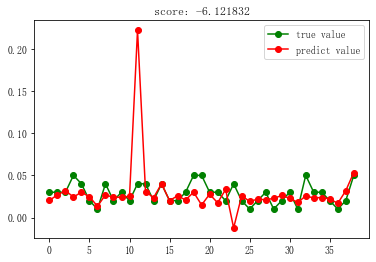

In [24]:
try_different_method(pcareg_model)

偏最小二乘法（Partial Least Squares）

In [100]:
# Partial Least Squares
from sklearn.cross_decomposition import PLSRegression
pls_model_setup = PLSRegression(scale=True)
param_grid = {'n_components': range(1, 14)}
search = GridSearchCV(pls_model_setup, param_grid,scoring='r2',cv=5)
search.fit(train_X, train_y)
search.best_params_
best_model=search.best_estimator_

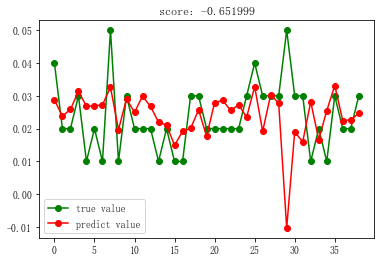

In [101]:
try_different_method(best_model)

In [102]:
score=[]
score=cross_val_score(best_model,data,target,cv=5,scoring='r2')
score.mean()

-3.3110690844952204

主成分回归和偏最小二乘感觉结果都不是很好。特别是主成分回归，感觉不如已有成果好，放弃

### 3.4 特征选择结论

目前所有的特征选择方法的结果如下：<br>

|岭回归                  |Lasso回归              |Elastic Net          |最小角度回归  |RFECV+AdaBoost|RFECV+岭回归            |RFECV+岭回归     |
|---------------------|---------------------|---------------------|--------|--------------|---------------------|--------------|
|前三年承诺覆盖率             |前三年承诺覆盖率             |前三年承诺覆盖率             |前三年承诺覆盖率|前三年承诺覆盖率      |净利润增长率               |动态市盈率         |
|净利润增长率               |净利润增长率               |净利润增长率               |净利润增长率  |D/(D+E)       |前三年承诺覆盖率             |流动比率          |
|成立年限                 |成立年限                 |成立年限                 |成立年限    |成立年限          |成立年限                 |静态市盈率         |
|动态市盈率                |研发支出占比               |研发支出占比               |固定资产周转率 |总资产增长率        |流动比率                 |总资产增长率        |
|流动比率                 |流动比率                 |流动比率                 |研发支出占比  |承诺期业绩增长率      |动态市盈率                |大股东持股比例       |
|固定资产周转率              |固定资产周转率              |固定资产周转率              |动态市盈率   |大股东持股比例       |固定资产周转率              |注入资产净资产账面值(万元）|
|D/(D+E)              |经营杠杆（EBITDA/EBIT)    |经营杠杆（EBITDA/EBIT)    |        |动态市盈率         |研发支出占比               |存货周转率         |
|存货周转率                |D/(D+E)              |存货周转率                |        |总资产周转率        |资产负债率                |成立年限          |
|承诺期业绩增长率             |存货周转率                |D/(D+E)              |        |上一年归母净利润（万元）  |存货周转率                |应收账款周转率       |
|大股东持股比例              |大股东持股比例              |大股东持股比例              |        |净资产收益率        |D/(D+E)              |毛利率           |
|研发支出占比               |动态市盈率                |动态市盈率                |        |              |最近一个完整会计年度对第一大客户的销售占比|承诺期业绩增长率      |
|净资产收益率               |毛利率                  |毛利率                  |        |              |承诺期业绩增长率             |净资产收益率        |
|毛利率                  |承诺期业绩增长率             |承诺期业绩增长率             |        |              |大股东持股比例              |总资产周转率        |
|最近一个完整会计年度对第一大客户的销售占比|最近一个完整会计年度对第一大客户的销售占比|最近一个完整会计年度对第一大客户的销售占比|        |              |净资产收益率               |资产负债率         |
|资产负债率                |审核结果                 |审核结果                 |        |              |注入资产净资产账面值(万元)       |              |
|经营杠杆（EBITDA/EBIT)    |净资产收益率               |净资产收益率               |        |              |经营杠杆（EBITDA/EBIT)    |              |
|在建工程/归母权益            |注入资产净资产账面值(万元)       |注入资产净资产账面值(万元)       |        |              |毛利率                  |              |
|注入资产净资产账面值(万元)       |在建工程/归母权益            |在建工程/归母权益            |        |              |                     |              |
|总资产周转率               |资产负债率                |资产负债率                |        |              |                     |              |
|上一年归母净利润（万元）         |总资产周转率               |总资产周转率               |        |              |                     |              |
|归母权益增长率              |                     |                     |        |              |                     |              |
|静态市盈率                |                     |                     |        |              |                     |              |
|经营性现金流/收入            |                     |                     |        |              |                     |              |
|总资产增长率               |                     |                     |        |              |                     |              |
|审核结果                 |                     |                     |        |              |                     |              |
|（固定资产+土地）/归母权益       |                     |                     |        |              |                     |              |
|最近一个完整会计年度对第一供应商的采购占比|                     |                     |        |              |                     |              |
|应收账款周转率              |                     |                     |        |              |                     |              |


从表格中我们可以看出，比较有效的指标是

## 4 基于特征选择结果进行调参

In [ ]:
#ttps://zhuanlan.zhihu.com/p/76206257